In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pandas as pd
import seaborn as sns

In [2]:
from weatherbench2.metrics import MAE, _spatial_average

In [3]:
import graphufs

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [4]:
plt.style.use("graphufs.plotstyle")

In [5]:
fig_dir = "figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [6]:
def swap_dims(xds):

    if "prediction_timedelta" in xds.coords and "lead_time" not in xds.coords:
        xds = xds.rename({"prediction_timedelta": "lead_time"})

    if "lead_time" in xds.coords:
        xds["fhr"] = (xds.lead_time.astype(int) / 3600 / 1e9).astype(int)
        xds = xds.swap_dims({"lead_time": "fhr"})
    return xds

In [7]:
def open_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [8]:
def open_zarr(*args, **kwargs):
    xds = xr.open_zarr(*args, **kwargs)
    xds = swap_dims(xds)
    return xds

In [16]:
truths = ["HRES Analysis"]
models = [
    "GraphUFS",
    "GraphCast",
#    "Pangu",
#    "ERA5 Forecasts",
    "IFS ENS Mean",
    "Replay Targets", # uncomment to show that interpolation error from 13 vs 128 levels does not matter
    "Replay",
]

In [17]:
duration = "240h"
year = 2018

location = "/p1-evaluation/v1/validation"

errors = {}

for model in models:
    name = model.lower().replace(" ", "_")
    errors[model] = {}
    middle = duration if model in ("GraphUFS", "Replay", "Replay Targets") else year
    
    for truth in truths:
        tname = truth.lower().replace(" ", "_")
        errors[model][truth] = open_dataset(f"{location}/{name}_vs_{tname}_{middle}_deterministic.nc")

In [18]:
class LinePlotter():

    @staticmethod
    def subplots(nrows, ncols, **kwargs):
        return plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*4), constrained_layout=True)

    @staticmethod
    def title(fldname):
        return " ".join([x.capitalize() if x != "of" else x for x in fldname.replace("_", " ").split(" ")])
        
    @staticmethod
    def nicefig(fig, metric, truth):
        fig.legend(loc="center left", bbox_to_anchor=(1, .5))
        mname = metric.upper() if metric != "bias" else "Bias"
        fig.suptitle(f"{mname} vs {truth}")
        
    def plot_surface(self, dsdict: dict, truth: str, metric: str = "mae", fields: tuple[str] = ("2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind")):
        
        fig, axs = self.subplots(1, len(fields))

        self._plot_row(axs, dsdict, truth, metric, fields)
        self.nicefig(fig, metric, truth)
        return fig, axs

    def plot_levels(self, dsdict: dict, truth: str, metric: str = "mae", fields: tuple[str] = ("temperature", "specific_humidity", "u_component_of_wind", "v_component_of_wind"), levels: tuple[int] = (100, 500, 850)):

        fig, axs = self.subplots(len(levels), len(fields))

        if len(levels) == 1:
            axs = [axs]
        
        for level, axr in zip(levels, axs):
            self._plot_row(axr, dsdict, truth, metric, fields, level=level)
            
        self.nicefig(fig, metric, truth)
        return fig, axs


    def _plot_row(self, axr, dsdict, truth, metric, fields, level=None):
        
        xticks = dsdict["GraphUFS"][truth].fhr.values[3::4]
        
        for fld, ax in zip(fields, axr):
            sps = ax.get_subplotspec()
            for j, (label, xdict) in enumerate(dsdict.items()):
                xds = xdict[truth]
                if label == "Replay":
                    color="gray"
                elif label == "Replay Targets":
                    color = "C5"
                elif label == "IFS ENS Mean":
                    color = "C3"
                else:
                    color = f"C{j}"
                
                kw = {
                    "color": color,
                    "label": label if sps.is_last_row() and sps.is_first_col() else None
                }
                plotme = xds[fld].sel(metric=metric)
                if level is not None:
                    if level in plotme.level:
                        plotme = plotme.sel(level=level)
                    else:
                        plotme = None

                if plotme is not None:
                    if "lead_time" in plotme.coords:
                        plotme.plot(ax=ax, **kw)
                    else:
                        ax.axhline(plotme, **kw)

                ax.set(
                    xlabel="Lead time (days)" if sps.is_last_row() else "",
                    ylabel="" if level is None or not sps.is_first_col() else f"{level} hPa",
                    title=self.title(fld) if sps.is_first_row() else "",
                    xticks=xticks,
                    xticklabels=[x//24 for x in xticks],
                    ylim=[0, None] if metric in ("mae", "mse") else [None, None],
                    xlim=[-6, 252],
                )

In [19]:
lp = LinePlotter()

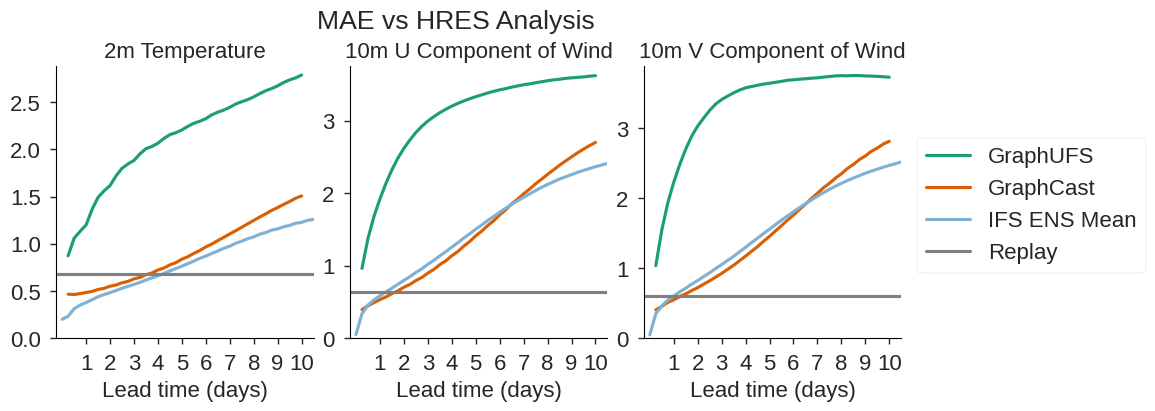

In [13]:
fig, axs = lp.plot_surface(errors, truth="HRES Analysis")

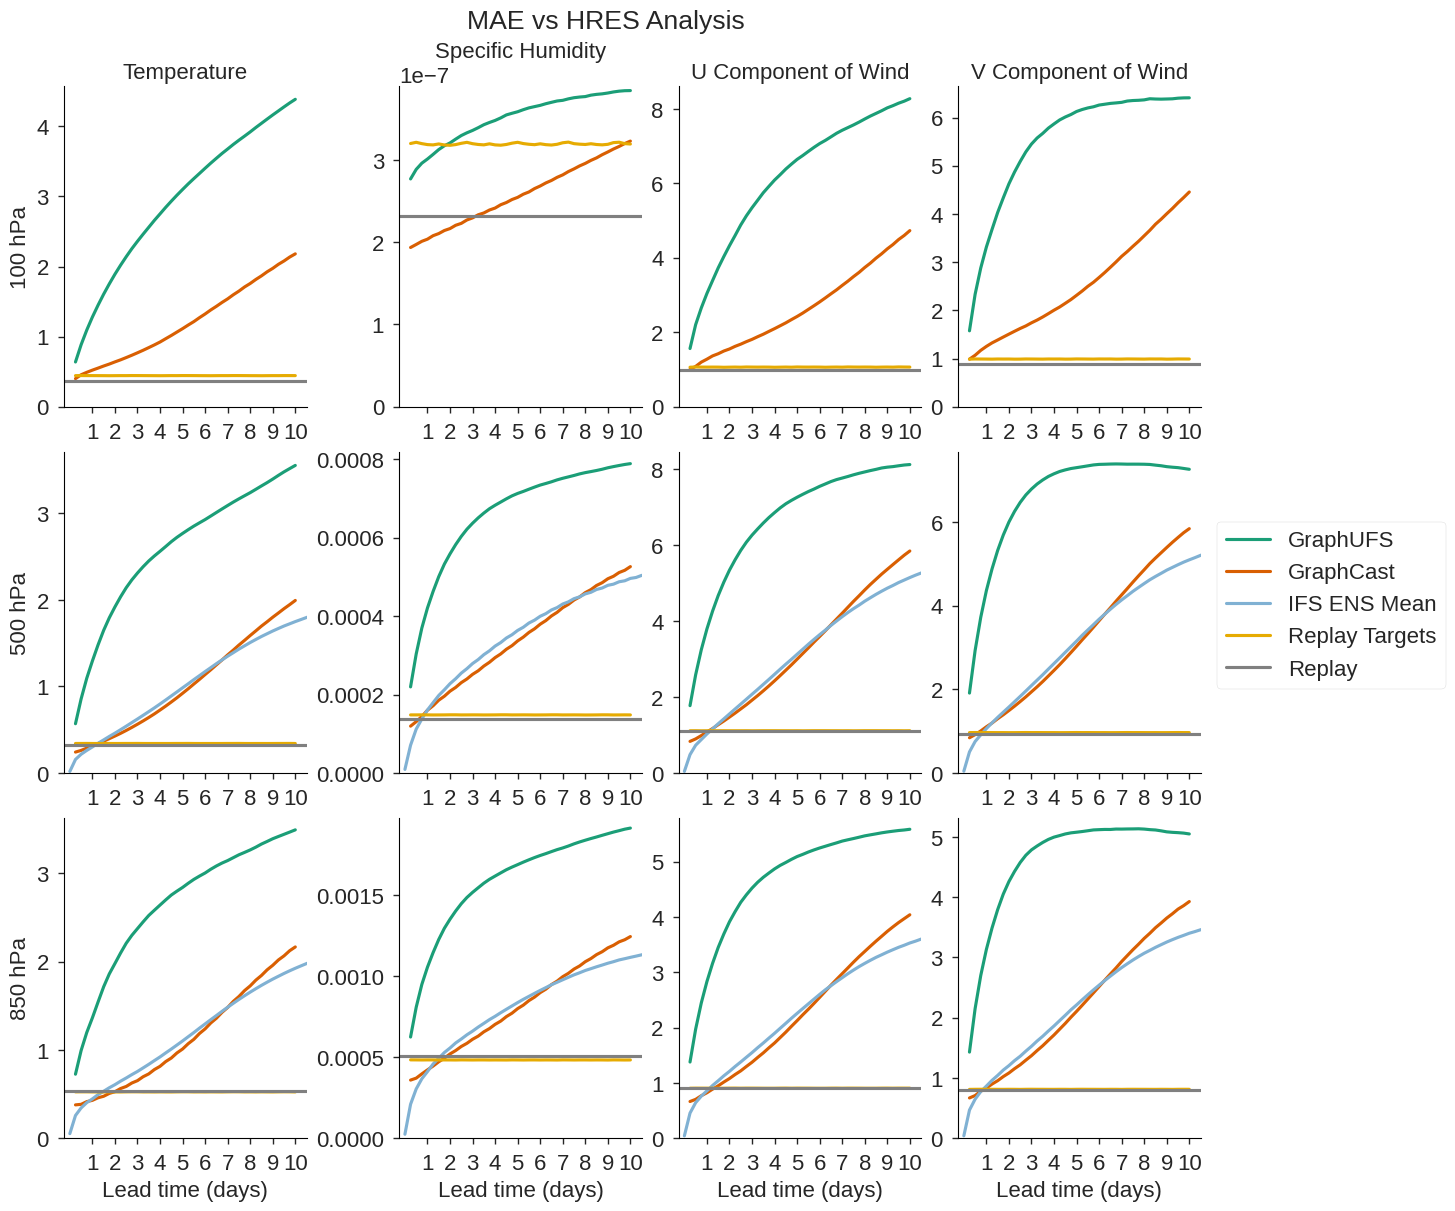

In [20]:
fig, axs = lp.plot_levels(errors, truth="HRES Analysis")
fig.savefig(f"{fig_dir}/mae_vs_hres_levels_vinterp.jpeg", bbox_inches="tight", dpi=300)

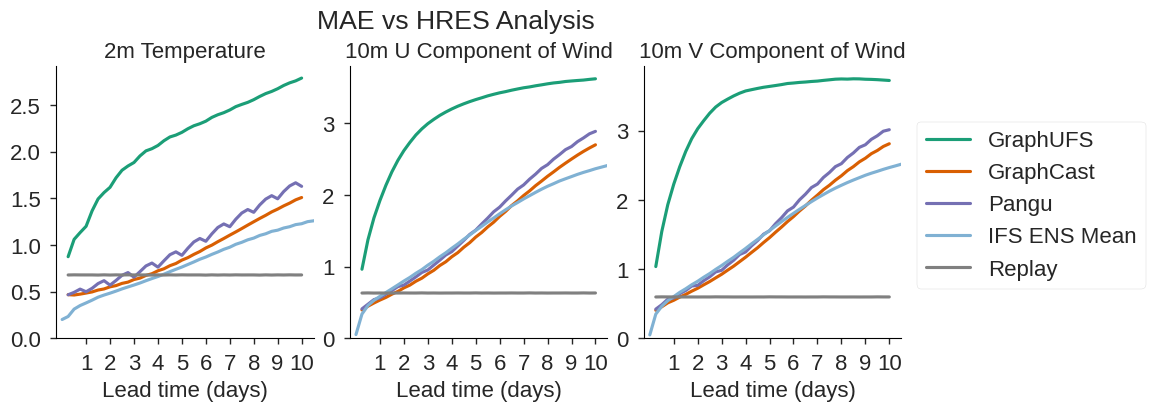

In [83]:
fig, axs = plot_surface_metrics(errors, truth="HRES Analysis")
#fig.savefig(f"{fig_dir}/mae_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

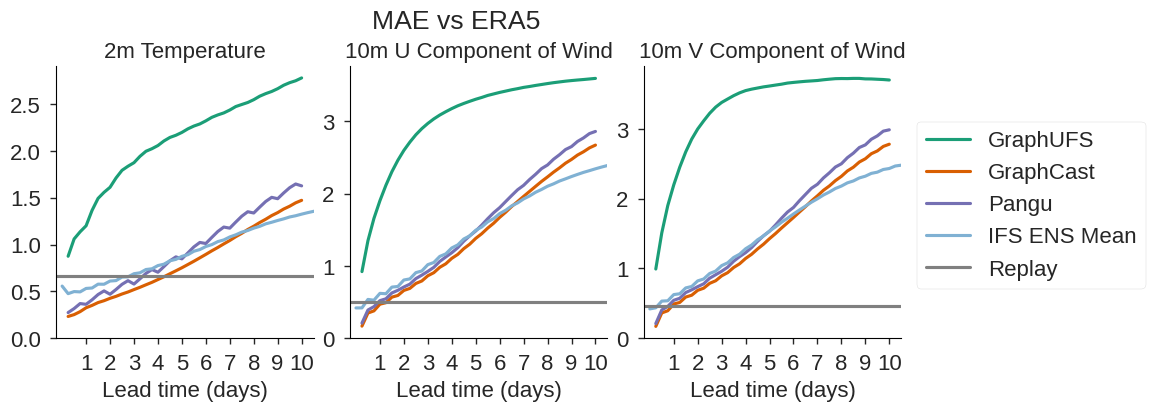

In [18]:
fig, axs = plot_surface_metrics(errors, truth="ERA5")
#fig.savefig(f"{fig_dir}/mae_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

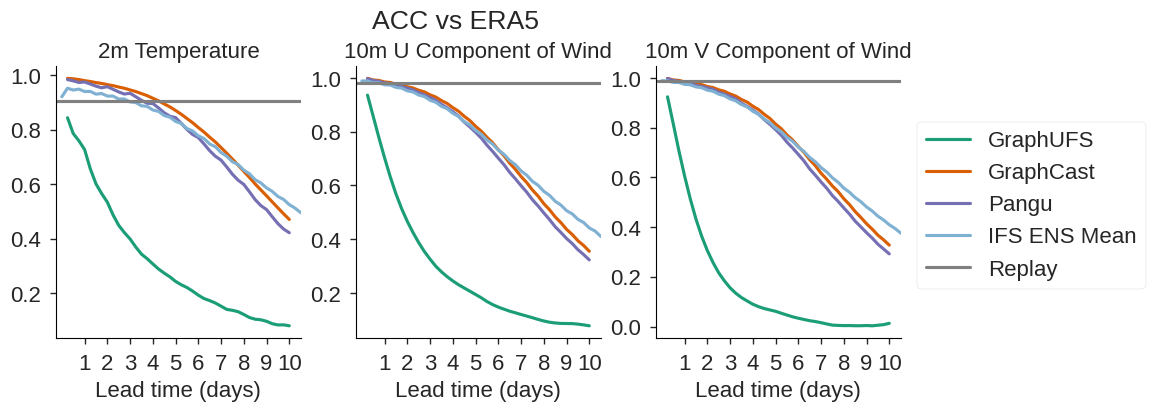

In [19]:
fig, axs = plot_surface_metrics(errors, truth="ERA5", metric="acc")
#fig.savefig(f"{fig_dir}/acc_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

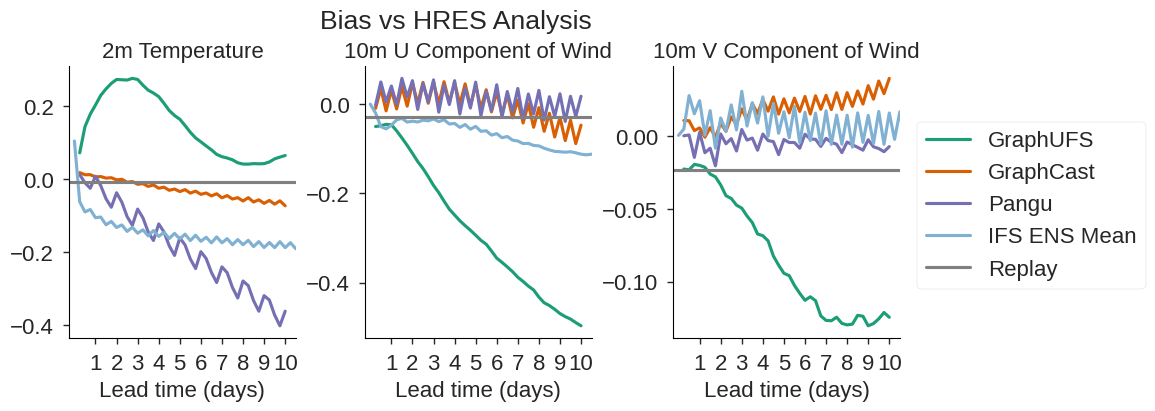

In [20]:
fig, axs = plot_surface_metrics(errors, truth="HRES Analysis", metric="bias")
#fig.savefig(f"{fig_dir}/bias_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

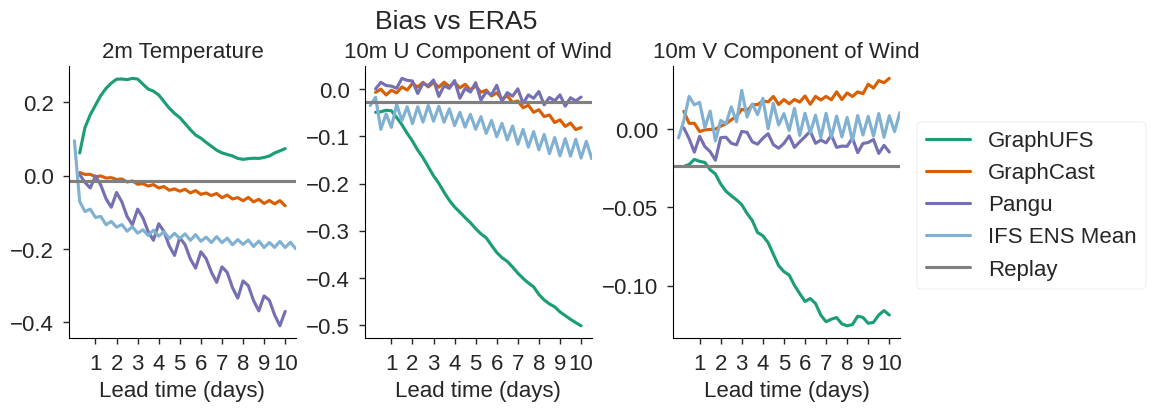

In [21]:
fig, axs = plot_surface_metrics(errors, truth="ERA5", metric="bias")
#fig.savefig(f"{fig_dir}/bias_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)

## Relative Error

Originally I was thinking
$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{trainer}_1, \text{trainer}_2)}$$

e.g. the ERA5 version of the plot shows

$$ \dfrac{|\text{GraphUFS} - \text{Replay}|}{|\text{Replay} - \text{ERA5}|}$$
or
$$ \dfrac{|\text{GraphCast} - \text{ERA5}|}{|\text{Replay} - \text{ERA5}|}$$
$$ \dfrac{|\text{Pangu} - \text{ERA5}|}{|\text{Replay} - \text{ERA5}|}$$
and same for Pangu.

Ideally we could also do

$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{trainer}, \text{independent dataset})}$$

But we don't have error between ERA5 and HRES Analysis immediately available, so the HRES version of the plot shows

$$ \dfrac{E(\text{model}, \text{trainer})}{E(\text{Replay}, \text{HRES Analysis})}$$

Which no matter what gives us some kind of independent estimate of "how close we should be" for the denominator, even when we use it on a dataset trained on ERA5.

In [88]:
gvr = open_dataset("/p1-evaluation/v1/validation/graphufs_vs_replay_240h_deterministic.nc")

In [89]:
relative_errors = {
    "GraphUFS": {
        "HRES Analysis": gvr / errors["Replay"]["HRES Analysis"],
        "ERA5": gvr / errors["Replay"]["ERA5"],
    },
}

In [90]:
for key in ["GraphCast", "Pangu"]:
    relative_errors[key] = {
        "HRES Analysis": errors[key]["ERA5"] / errors["Replay"]["HRES Analysis"],
        "ERA5": errors[key]["ERA5"] / errors["Replay"]["ERA5"],
    }

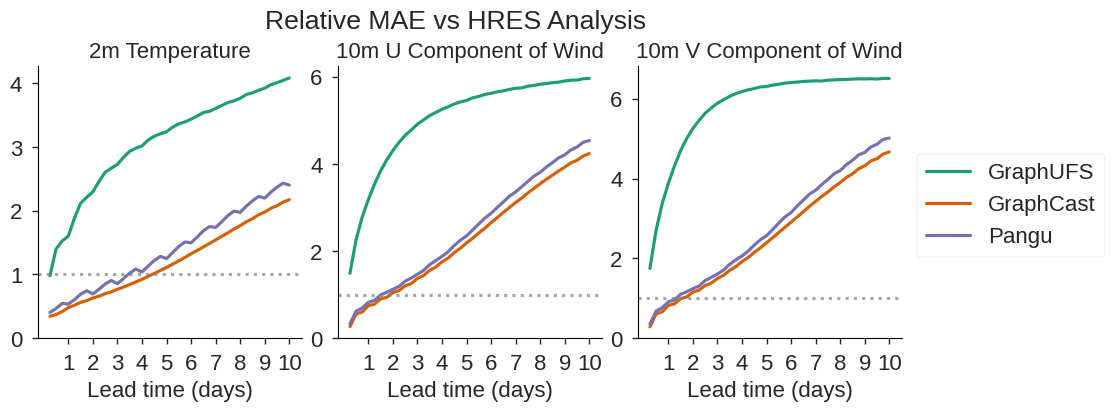

In [91]:
fig, axs = plot_surface_metrics(
    mds=relative_errors,
    truth="HRES Analysis",
)
fig.suptitle("Relative MAE vs HRES Analysis")
[ax.axhline(y=1, ls=":", alpha=.7, color="gray") for ax in axs]
fig.savefig(f"{fig_dir}/relative_mae_vs_hres_surface.jpeg", bbox_inches="tight", dpi=300)

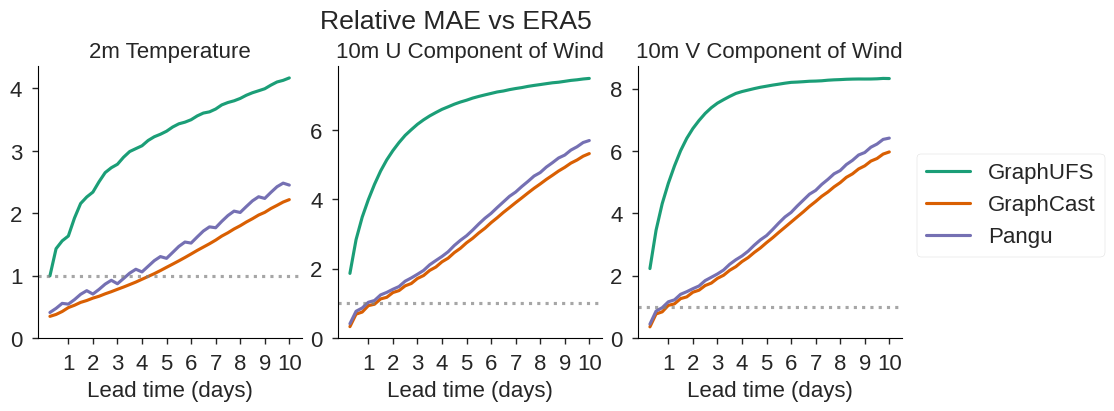

In [92]:
fig, axs = plot_surface_metrics(
    mds=relative_errors,
    truth="ERA5",
)
fig.suptitle("Relative MAE vs ERA5")
[ax.axhline(y=1, ls=":", alpha=.7, color="gray") for ax in axs]
fig.savefig(f"{fig_dir}/relative_mae_vs_era5_surface.jpeg", bbox_inches="tight", dpi=300)